# CFBStats Multi-Year EDA

This notebook explores season-level summary tables pulled from cfbstats.com for a given college football team (2016-2025). Each season includes:

- the primary team statistics table (points, efficiency metrics, etc.)
- a companion table containing the overall record (`All Games`) used to annotate each season

The analysis below consolidates these sources into a single DataFrame and produces a few quick comparisons across seasons.


In [279]:
from pathlib import Path
import re
from typing import Dict, List, Optional

import matplotlib.pyplot as plt
import pandas as pd

plt.style.use("seaborn-v0_8")
pd.set_option("display.precision", 2)



In [280]:
"""
OPTIONS: 
virginia_cavaliers, boston_college_eagles, duke_blue_devils,
alabama_crimson_tide, auburn_tigers, florida_gators,
tulane_green_wave, tulsa_golden_hurricane, temple_owls
"""
team = "virginia_cavaliers"
team_name = "Virginia"

In [281]:
DATA_DIR = Path(f"data/scraped")
pattern = re.compile(r"^(?P<year>\d{4})_index_.*\.csv$")

main_tables: List[tuple[int, Path]] = []
for path in DATA_DIR.glob(f"*_index_*_{team}_through_*.csv"):
    stem = path.stem
    if stem.endswith(('_2', '_3')):
        continue
    match = pattern.match(path.name)
    if match:
        main_tables.append((int(match.group("year")), path))

main_tables = sorted(main_tables, key=lambda x: x[0])
main_tables


[(2016,
  PosixPath('data/scraped/2016_index_2016_virginia_cavaliers_through_01092017.csv')),
 (2017,
  PosixPath('data/scraped/2017_index_2017_virginia_cavaliers_through_01082018.csv')),
 (2018,
  PosixPath('data/scraped/2018_index_2018_virginia_cavaliers_through_01072019.csv')),
 (2019,
  PosixPath('data/scraped/2019_index_2019_virginia_cavaliers_through_01132020.csv')),
 (2020,
  PosixPath('data/scraped/2020_index_2020_virginia_cavaliers_through_01112021.csv')),
 (2021,
  PosixPath('data/scraped/2021_index_2021_virginia_cavaliers_through_01102022.csv')),
 (2022,
  PosixPath('data/scraped/2022_index_2022_virginia_cavaliers_through_01092023.csv')),
 (2023,
  PosixPath('data/scraped/2023_index_2023_virginia_cavaliers_through_01082024.csv')),
 (2024,
  PosixPath('data/scraped/2024_index_2024_virginia_cavaliers_through_01202025.csv')),
 (2025,
  PosixPath('data/scraped/2025_index_2025_virginia_cavaliers_through_11152025.csv'))]

In [282]:
def parse_numeric(value: object) -> Optional[float]:
    if pd.isna(value):
        return None
    if isinstance(value, (int, float)):
        return float(value)

    cleaned = str(value).strip()
    if not cleaned:
        return None

    cleaned = cleaned.replace(",", "")

    if cleaned.endswith("%"):
        try:
            return float(cleaned.rstrip("%"))
        except ValueError:
            return None

    if re.fullmatch(r"\d+:\d{2}(?:\.\d+)?", cleaned):
        minutes, seconds = cleaned.split(":")
        try:
            return int(minutes) + float(seconds) / 60.0
        except ValueError:
            return None

    numbers = re.findall(r"-?\d+(?:\.\d+)?", cleaned)
    if len(numbers) == 1:
        return float(numbers[0])

    return None


def load_main_table(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    metric_col = df.columns[0]
    df = df.rename(columns={metric_col: "Metric"})
    df["Metric"] = df["Metric"].str.strip()
    return df.set_index("Metric")


def load_record(path: Path) -> Optional[str]:
    record_path = path.with_name(f"{path.stem}_3.csv")
    if not record_path.exists():
        return None

    df = pd.read_csv(record_path)
    split_col = df.columns[0]
    df = df.rename(columns={split_col: "Split"})
    df["Split"] = df["Split"].str.strip()
    match = df.loc[df["Split"] == "All Games"]
    if match.empty:
        return None
    return str(match.iloc[0, 1]).strip()


def parse_record(record: Optional[str]) -> tuple[Optional[int], Optional[int], Optional[int]]:
    if not record:
        return None, None, None

    m = re.match(r"^(\d+)-(\d+)(?:-(\d+))?", record)
    if not m:
        return None, None, None
    wins = int(m.group(1))
    losses = int(m.group(2))
    ties = int(m.group(3)) if m.group(3) is not None else 0
    return wins, losses, ties



In [283]:
METRICS: Dict[str, str] = {
    "Scoring: Points/Game": "points_per_game",
    "Rushing: Yards / Attempt": "rush_yards_per_attempt",
    "Passing: Yards": "pass_yards",
    "Total Offense: Yards / Play": "yards_per_play",
    "Time of Possession / Game": "time_of_possession_minutes",
    "3rd Down Conversions: Conversion %": "third_down_pct",
    "4th Down Conversions: Conversion %": "fourth_down_pct",
    "Field Goals: Success %": "field_goal_pct",
}

seasons: List[Dict[str, object]] = []

for year, path in main_tables:
    table = load_main_table(path)
    record_str = load_record(path)
    wins, losses, ties = parse_record(record_str)

    stats: Dict[str, object] = {
        "year": year,
        "record": record_str,
        "wins": wins,
        "losses": losses,
        "ties": ties,
    }

    for metric_label, field_name in METRICS.items():
        if metric_label in table.index:
            stats[f"{field_name}_for"] = parse_numeric(table.loc[metric_label, team_name])
            stats[f"{field_name}_against"] = parse_numeric(table.loc[metric_label, "Opponents"])

    seasons.append(stats)

season_df = pd.DataFrame(seasons).sort_values("year").reset_index(drop=True)
season_df


,year,record,wins,losses,ties,points_per_game_for,points_per_game_against,rush_yards_per_attempt_for,rush_yards_per_attempt_against,pass_yards_for,...,yards_per_play_for,yards_per_play_against,time_of_possession_minutes_for,time_of_possession_minutes_against,third_down_pct_for,third_down_pct_against,fourth_down_pct_for,fourth_down_pct_against,field_goal_pct_for,field_goal_pct_against
0,2016,2-10,2,10,0,22.5,33.8,3.55,4.70,2872.0,...,4.86,6.33,29.01,30.99,34.62,43.35,52.17,53.33,50.0,76.2
1,2017,6-7,6,7,0,22.5,28.4,3.13,4.65,3233.0,...,4.90,5.40,30.47,29.53,39.23,36.70,39.29,57.69,66.7,64.3
2,2018,8-5,8,5,0,28.5,20.1,4.51,4.34,2751.0,...,5.84,5.27,32.56,27.44,49.12,40.33,61.54,43.48,68.2,76.2
3,2019,9-5,9,5,0,32.1,27.1,3.84,3.89,3748.0,...,5.66,5.75,33.06,26.94,45.32,36.02,56.25,52.00,83.3,71.4
4,2020,5-5,5,5,0,30.7,29.6,4.45,3.74,2606.0,...,5.68,6.39,31.06,28.94,37.06,41.67,64.00,33.33,76.9,82.6
5,2021,6-6,6,6,0,34.6,31.8,4.38,5.79,4711.0,...,6.95,6.63,30.64,29.29,45.91,40.99,42.11,63.16,78.9,65.2
6,2022,3-7,3,7,0,17.0,24.0,3.74,3.76,2210.0,...,5.13,4.97,27.57,32.43,32.12,36.60,38.89,57.14,61.1,82.6
7,2023,3-9,3,9,0,23.3,33.8,3.12,5.10,3010.0,...,5.21,6.05,31.41,28.59,36.07,40.37,60.00,57.89,85.7,85.0
8,2024,5-7,5,7,0,22.7,28.8,3.66,4.13,2748.0,...,5.20,6.02,29.90,30.10,34.25,38.55,51.72,62.50,85.7,74.1
9,2025,9-2,9,2,0,33.7,21.2,4.80,3.30,2751.0,...,5.96,5.02,31.90,28.10,49.16,28.48,45.83,58.33,81.8,71.4


In [284]:
derived_df = season_df.copy()

# Add team column as the first column
derived_df.insert(0, "team", team_name)

# Derive win percentage; guard against missing records
win_totals = derived_df[["wins", "losses", "ties"]].fillna(0)
total_games = win_totals.sum(axis=1).replace(0, pd.NA)

derived_df["win_pct"] = win_totals["wins"] / total_games

derived_df["scoring_margin"] = (
    derived_df["points_per_game_for"] - derived_df["points_per_game_against"]
)

derived_df["rush_ypa_margin"] = (
    derived_df["rush_yards_per_attempt_for"] - derived_df["rush_yards_per_attempt_against"]
)

derived_df["third_down_margin"] = (
    derived_df["third_down_pct_for"] - derived_df["third_down_pct_against"]
)

derived_df


,team,year,record,wins,losses,ties,points_per_game_for,points_per_game_against,rush_yards_per_attempt_for,rush_yards_per_attempt_against,...,third_down_pct_for,third_down_pct_against,fourth_down_pct_for,fourth_down_pct_against,field_goal_pct_for,field_goal_pct_against,win_pct,scoring_margin,rush_ypa_margin,third_down_margin
0,Virginia,2016,2-10,2,10,0,22.5,33.8,3.55,4.70,...,34.62,43.35,52.17,53.33,50.0,76.2,0.17,-11.3,-1.15,-8.73
1,Virginia,2017,6-7,6,7,0,22.5,28.4,3.13,4.65,...,39.23,36.70,39.29,57.69,66.7,64.3,0.46,-5.9,-1.52,2.53
2,Virginia,2018,8-5,8,5,0,28.5,20.1,4.51,4.34,...,49.12,40.33,61.54,43.48,68.2,76.2,0.62,8.4,0.17,8.79
3,Virginia,2019,9-5,9,5,0,32.1,27.1,3.84,3.89,...,45.32,36.02,56.25,52.00,83.3,71.4,0.64,5.0,-0.05,9.30
4,Virginia,2020,5-5,5,5,0,30.7,29.6,4.45,3.74,...,37.06,41.67,64.00,33.33,76.9,82.6,0.50,1.1,0.71,-4.61
5,Virginia,2021,6-6,6,6,0,34.6,31.8,4.38,5.79,...,45.91,40.99,42.11,63.16,78.9,65.2,0.50,2.8,-1.41,4.92
6,Virginia,2022,3-7,3,7,0,17.0,24.0,3.74,3.76,...,32.12,36.60,38.89,57.14,61.1,82.6,0.30,-7.0,-0.02,-4.48
7,Virginia,2023,3-9,3,9,0,23.3,33.8,3.12,5.10,...,36.07,40.37,60.00,57.89,85.7,85.0,0.25,-10.5,-1.98,-4.30
8,Virginia,2024,5-7,5,7,0,22.7,28.8,3.66,4.13,...,34.25,38.55,51.72,62.50,85.7,74.1,0.42,-6.1,-0.47,-4.30
9,Virginia,2025,9-2,9,2,0,33.7,21.2,4.80,3.30,...,49.16,28.48,45.83,58.33,81.8,71.4,0.82,12.5,1.50,20.68


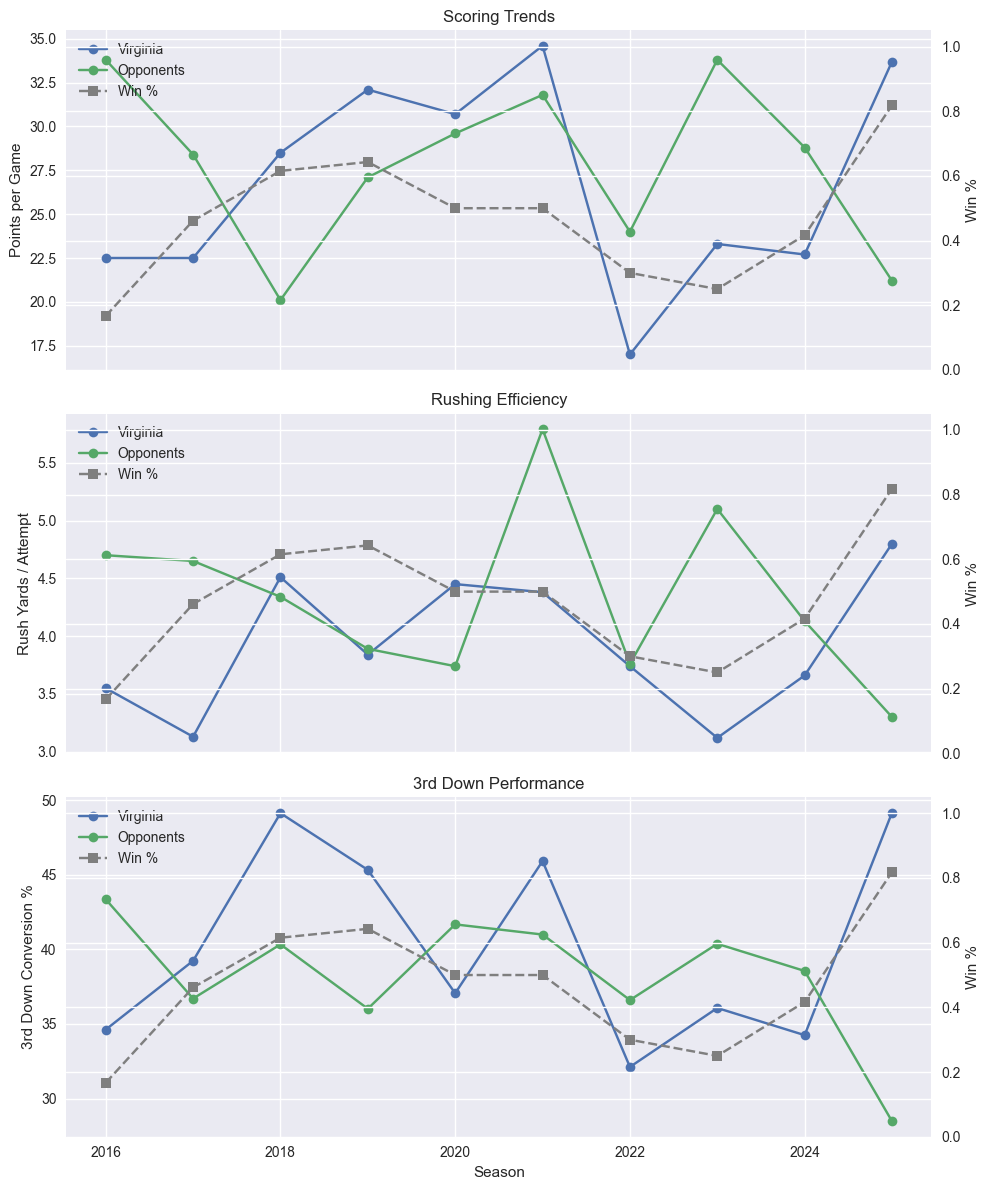

In [285]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12), sharex=True)
years = derived_df["year"]
win_pct = derived_df["win_pct"]

axes[0].plot(years, derived_df["points_per_game_for"], marker="o", label=team_name)
axes[0].plot(years, derived_df["points_per_game_against"], marker="o", label="Opponents")
axes[0].set_ylabel("Points per Game")
axes[0].set_title("Scoring Trends")

axes[1].plot(years, derived_df["rush_yards_per_attempt_for"], marker="o", label=team_name)
axes[1].plot(years, derived_df["rush_yards_per_attempt_against"], marker="o", label="Opponents")
axes[1].set_ylabel("Rush Yards / Attempt")
axes[1].set_title("Rushing Efficiency")

axes[2].plot(years, derived_df["third_down_pct_for"], marker="o", label=team_name)
axes[2].plot(years, derived_df["third_down_pct_against"], marker="o", label="Opponents")
axes[2].set_ylabel("3rd Down Conversion %")
axes[2].set_xlabel("Season")
axes[2].set_title("3rd Down Performance")

# Overlay win percentage on each subplot for easy comparison
twin_axes = []
for ax in axes:
    twin = ax.twinx()
    twin.plot(years, win_pct, color="tab:gray", marker="s", linestyle="--", label="Win %")
    twin.set_ylabel("Win %")
    twin.set_ylim(0, 1.05)
    twin_axes.append(twin)

# Build combined legends (primary + twin axes)
for ax, twin in zip(axes, twin_axes):
    handles, labels = [], []
    for axis in (ax, twin):
        h, l = axis.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    ax.legend(handles, labels, loc="upper left")

plt.tight_layout()
plt.show()



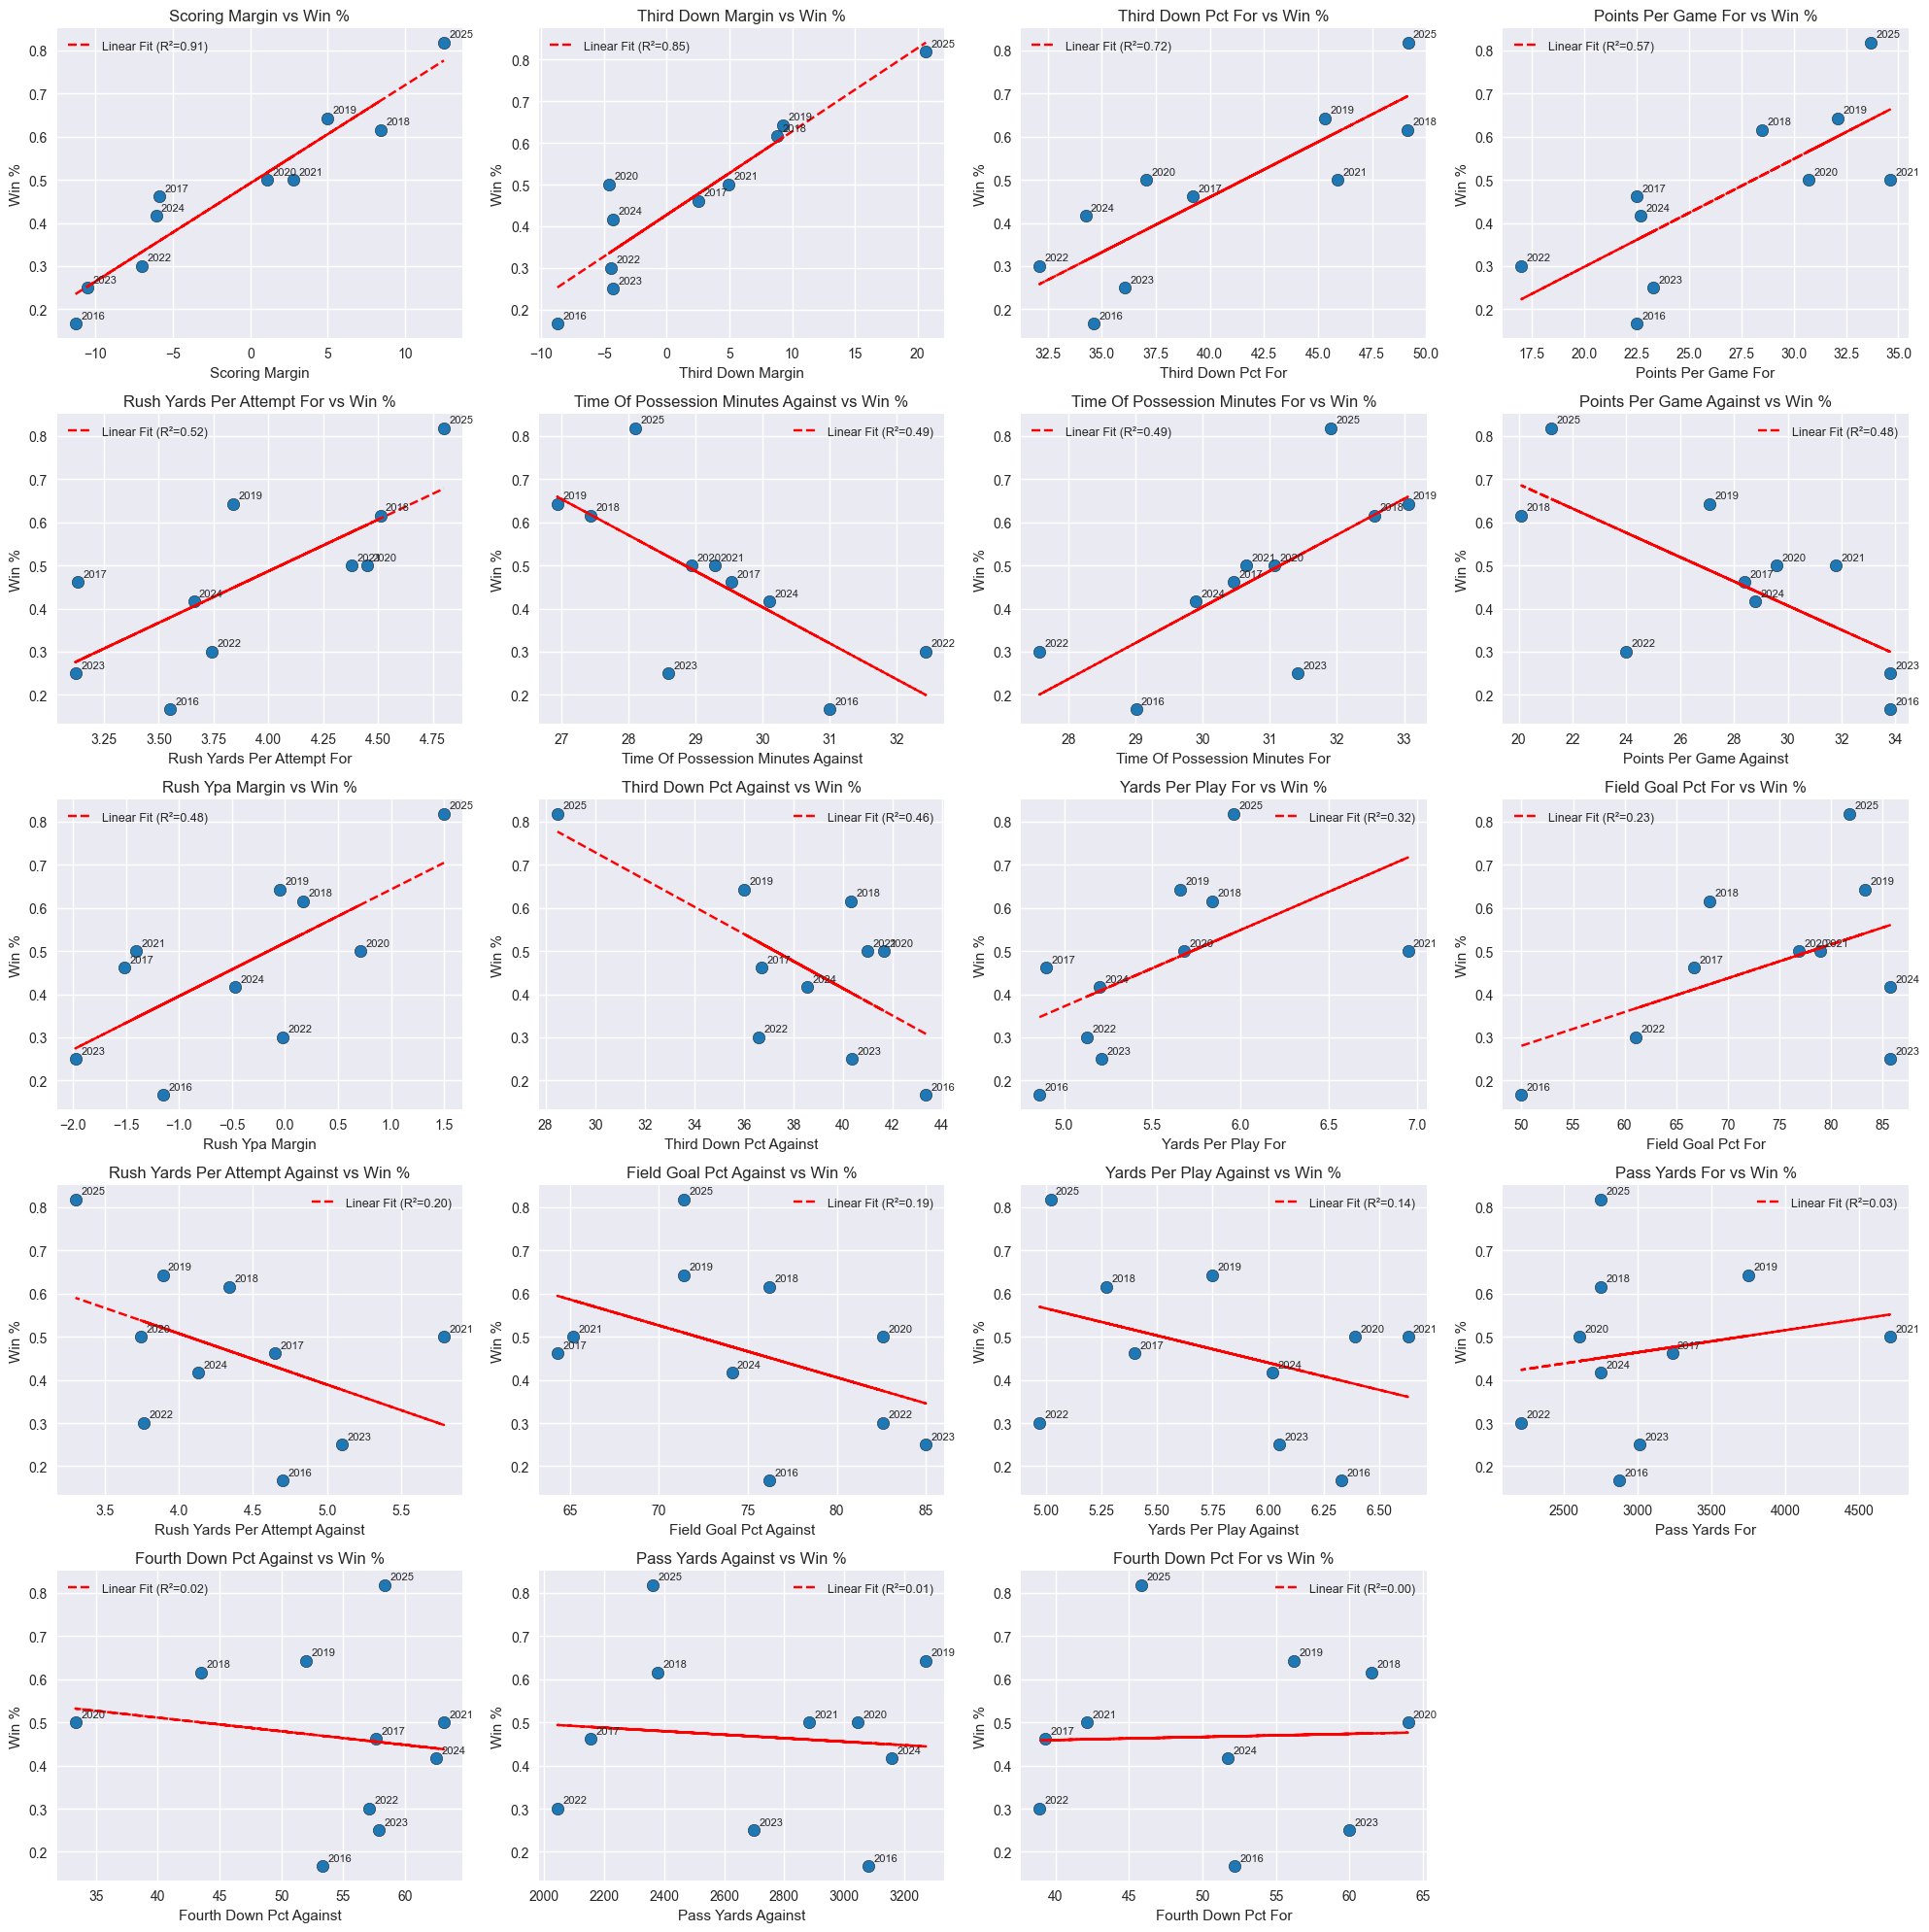

In [286]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import numpy as np

# Define columns to exclude from plotting against win_pct
excluded_cols = ["year", "record", "wins", "losses", "ties", "win_pct"]

# Get all other numeric columns to plot against win_pct
numeric_cols = [
    col for col in derived_df.columns
    if col not in excluded_cols and pd.api.types.is_numeric_dtype(derived_df[col])
]

# Calculate R^2 for each metric and store them
r_squared_values = []
for metric in numeric_cols:
    temp_df = derived_df[[metric, "win_pct"]].dropna()
    if not temp_df.empty:
        X = temp_df[[metric]]
        y = temp_df["win_pct"]
        model = LinearRegression()
        model.fit(X, y)
        y_pred = model.predict(X)
        r_squared = r2_score(y, y_pred)
        r_squared_values.append((r_squared, metric))

# Sort metrics by R^2 in decreasing order
r_squared_values.sort(key=lambda x: x[0], reverse=True)
plot_metrics_sorted = [metric for r_sq, metric in r_squared_values]

num_metrics = len(plot_metrics_sorted)
ncols = 4  # Number of columns for the subplot grid
nrows = (num_metrics + ncols - 1) // ncols  # Calculate number of rows needed

fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 5, nrows * 4))
axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration

for i, metric in enumerate(plot_metrics_sorted):
    ax = axes[i]

    # Prepare data for regression, dropping NaNs if any
    # Ensure 'year' is included for annotations
    temp_df = derived_df[[metric, "win_pct", "year"]].dropna()

    if temp_df.empty:
        ax.set_visible(False)  # Hide subplot if no data
        continue

    X = temp_df[[metric]]
    y = temp_df["win_pct"]
    years_for_annotate = temp_df["year"]

    # Recalculate R^2 (or retrieve from stored value) for plotting label
    model = LinearRegression()
    model.fit(X, y)
    y_pred = model.predict(X)
    r_squared = r2_score(y, y_pred)

    # Plot scatter points
    ax.scatter(
        X,
        y,
        s=80,
        edgecolor="black",
        facecolor="tab:blue",
    )

    # Add year annotations
    for x_val, y_val, year_val in zip(X[metric], y, years_for_annotate):
        ax.annotate(str(year_val), (x_val, y_val), textcoords="offset points", xytext=(4, 4), fontsize=8)

    # Add linear regression line and R^2 to the plot
    ax.plot(X, y_pred, color='red', linestyle='--', label=f'Linear Fit (R²={r_squared:.2f})')

    # Set labels and title
    formatted_metric_name = metric.replace('_', ' ').title()
    ax.set_xlabel(formatted_metric_name)
    ax.set_ylabel("Win %")
    ax.set_title(f"{formatted_metric_name} vs Win %")
    ax.legend(loc='best', fontsize=9)

# Turn off any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


In [287]:
summary_cols = [
    "year",
    "record",
    "win_pct",
    "points_per_game_for",
    "points_per_game_against",
    "scoring_margin",
    "rush_yards_per_attempt_for",
    "rush_yards_per_attempt_against",
    "third_down_pct_for",
    "third_down_pct_against",
]

summary_df = derived_df[summary_cols].set_index("year")
summary_df.round(3)



,record,win_pct,points_per_game_for,points_per_game_against,scoring_margin,rush_yards_per_attempt_for,rush_yards_per_attempt_against,third_down_pct_for,third_down_pct_against
year,,,,,,,,,
2016,2-10,0.17,22.5,33.8,-11.3,3.55,4.70,34.62,43.35
2017,6-7,0.46,22.5,28.4,-5.9,3.13,4.65,39.23,36.70
2018,8-5,0.61,28.5,20.1,8.4,4.51,4.34,49.12,40.33
2019,9-5,0.64,32.1,27.1,5.0,3.84,3.89,45.32,36.02
2020,5-5,0.50,30.7,29.6,1.1,4.45,3.74,37.06,41.67
2021,6-6,0.50,34.6,31.8,2.8,4.38,5.79,45.91,40.99
2022,3-7,0.30,17.0,24.0,-7.0,3.74,3.76,32.12,36.60
2023,3-9,0.25,23.3,33.8,-10.5,3.12,5.10,36.07,40.37
2024,5-7,0.42,22.7,28.8,-6.1,3.66,4.13,34.25,38.55


In [288]:
derived_df.to_csv(f"data/teams/{team}.csv", index=False)

In [289]:
import os

# Combine all CSVs in the base of the "data" folder (exclude subfolders)
data_folder = "data/teams"
csv_files = [f for f in os.listdir(data_folder)
             if f.endswith('.csv') and os.path.isfile(os.path.join(data_folder, f))]

df_list = []
for fname in csv_files:
    path = os.path.join(data_folder, fname)
    df = pd.read_csv(path)
    df_list.append(df)

combined_df = pd.concat(df_list, ignore_index=True)

combined_df.to_csv("data/all_teams.csv", index=False)